In [41]:
import tqdm
import numpy  as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from matplotlib import pyplot as plt
from tensorflow import keras
from keras      import layers,models
from sklearn.metrics import roc_curve
from tabulate        import tabulate

## Time to get your hands dirty. Galaxies vs quasars with neural networks.

Let's go back to our galaxy vs quasar data we've used in a previous exercise. 

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

In [2]:
data = pd.read_csv("galaxyquasar.csv")

In [3]:
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [4]:
u_g = np.array(data['u'] - data['g'])
g_r = np.array(data['g'] - data['r'])
r_i = np.array(data['r'] - data['i'])
i_z = np.array(data['i'] - data['z'])

# 1 = quasar 0 = galaxy
labels  = np.array(data['class']=='QSO', dtype='int')

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

In [5]:
# normalize to zero mean and unit variance for easier training
colors = np.zeros((len(data), 4), dtype = np.float32)

colors[:, 0] = (u_g - u_g.mean()) / u_g.std()
colors[:, 1] = (g_r - g_r.mean()) / g_r.std()
colors[:, 2] = (r_i - r_i.mean()) / r_i.std()
colors[:, 3] = (i_z - i_z.mean()) / i_z.std()

Unlike sklearn, tensorflow doesn't have a build-in splitting function, so I must create it:

In [6]:
# Create the dataset with tensorflow
dataset = tf.data.Dataset.from_tensor_slices((colors, labels))

2024-09-10 01:02:46.650276: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-10 01:02:47.061454: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
# do a 30% test 70% train split
dataset_size = dataset.cardinality().numpy()

train_ratio = 0.7
train_size  = int(train_ratio * dataset_size)
test_size   = int(dataset_size - train_size)

# Split the dataset into train and test
train = dataset.take(train_size)
test  = dataset.skip(train_size)

3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the [multilayer perceptron classifier](sklearn.neural_network.MLPClassifier) implemented in scikit-learn. My solution uses the latter, but this is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

In [8]:
def dense_layer(x, num_neurons):
    x = layers.Dense(num_neurons, activation='relu')(x)
    return x

def simple_model(l:int, num_neurons:int):
    # the input is (height, width, channels)
    inputs = layers.Input(shape=(l,))
    # 5 is the number of neuron in the Dense layer, as specified
    # keras only needs to know the number of features, in this case: 4
    x       = dense_layer(inputs, num_neurons)
    # now I want to obtain a probability for a class
    # so I output a single neuron with a dense layer
    # the sigmoid activation function gives a value between 0 and 1, so a probability
    # sigmoid(x) = 1 / (1 + exp(-1))
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model   = tf.keras.Model(inputs, outputs, name='simple_model')

    return model

In [9]:
model = simple_model(l=4, num_neurons=5)

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
# BATCH size refers to the number of training examples utilized in one iteration (to update the weights)
batch_size = 64

# when shuffling we do not take the entire dataset, but only a part of it of the size of the BUFFER
# when we pick an example to use in the batch we take it from the buffer,
# the size is fixed, so it is immediately filled with another element from the dataset
# it's to introduce more randomness
buffer_size = 1000

# STEPS are to ensure that we iterate through the entire training dataset in each epoch
steps_per_epochs = train_size // batch_size
# NB: an epoch is one complete pass through the entire training dataset during the training of a neural network

In [12]:
train_batches = (
    train
    # Caching the dataset after the first epoch.
    # This can speed up data loading in subsequent epochs by keeping the data in memory or on disk
    .cache()
    # Shuffling the dataset to mantain randomness
    .shuffle(buffer_size)
    # Create batch of the shuffled data
    .batch(batch_size)
    # Repeating the dataset indefinitely to ensure the model sees the entire dataset in each epoch
    .repeat()
    # Prefetching data to overlap the data loading and model training
    .prefetch(buffer_size=tf.data.AUTOTUNE))

# Create the batches for the tests and validation
# I want to further divide my dataset because I want to leave out a test subu-dataset to check the performance of the model later
validation_ratio = 0.5
validation_size  = int(test_size * validation_ratio)

validation_batches = test.take(validation_size).batch(batch_size)

test = test.skip(validation_size)

In [13]:
# The model will go through the entire training dataset *EPOCHS* times during training
epochs = 50

#  How many batches of the validation dataset are used for validation during each validation epoch
val_subsplits = 5
validation_steps = test_size//batch_size// val_subsplits


# For each epoch, the model first train on the training data updating its weights,
# then the model is evaluated on batches of validation data, without updating the weights
# This alternating process allows the model to learn from the training data
# and assess its generalization performance on the validation data
model_history = model.fit(train_batches, epochs = epochs,
                          steps_per_epoch = steps_per_epochs,
                          validation_steps = validation_steps,
                          validation_data = validation_batches)

Epoch 1/50
546/546 [==============================] - 3s 4ms/step - loss: 0.4226 - accuracy: 0.8487 - val_loss: 0.2527 - val_accuracy: 0.9361
Epoch 2/50
546/546 [==============================] - 1s 3ms/step - loss: 0.1719 - accuracy: 0.9697 - val_loss: 0.1190 - val_accuracy: 0.9786
Epoch 3/50
546/546 [==============================] - 2s 3ms/step - loss: 0.1064 - accuracy: 0.9796 - val_loss: 0.0853 - val_accuracy: 0.9796
Epoch 4/50
546/546 [==============================] - 2s 3ms/step - loss: 0.0886 - accuracy: 0.9809 - val_loss: 0.0738 - val_accuracy: 0.9800
Epoch 5/50
546/546 [==============================] - 1s 3ms/step - loss: 0.0816 - accuracy: 0.9816 - val_loss: 0.0688 - val_accuracy: 0.9800
Epoch 6/50
546/546 [==============================] - 2s 3ms/step - loss: 0.0781 - accuracy: 0.9817 - val_loss: 0.0668 - val_accuracy: 0.9813
Epoch 7/50
546/546 [==============================] - 1s 3ms/step - loss: 0.0765 - accuracy: 0.9821 - val_loss: 0.0656 - val_accuracy: 0.9813
Epoch 

In [14]:
def display_learning_curves(history):

    acc      = history["accuracy"]
    val_acc  = history["val_accuracy"]

    loss     = history["loss"]
    val_loss = history["val_loss"]

    epochs_range = range(epochs)

    fig = plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validation accuracy")
    plt.ylim(0.95,1)
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validation loss")
    plt.ylim(0,0.3)
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    fig.tight_layout()
    plt.show()

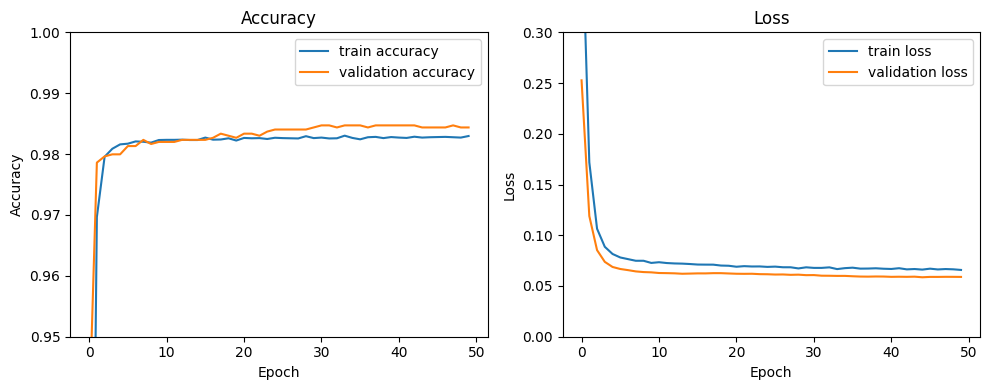

In [15]:
# Display learning curves
display_learning_curves(model_history.history)

In [16]:
test_size = test.cardinality().numpy()

predictions = []
ytrue = []

for features, labels in test.take(test_size):
    # I need to add tf.newaxis at the beginning because the model accepts an input shape of dimension #batches, features
    pred = model.predict(features[tf.newaxis, ...], verbose = 0)
    pred = np.round(pred)
    predictions.append(int(pred[0][0]))
    ytrue.append(labels.numpy())

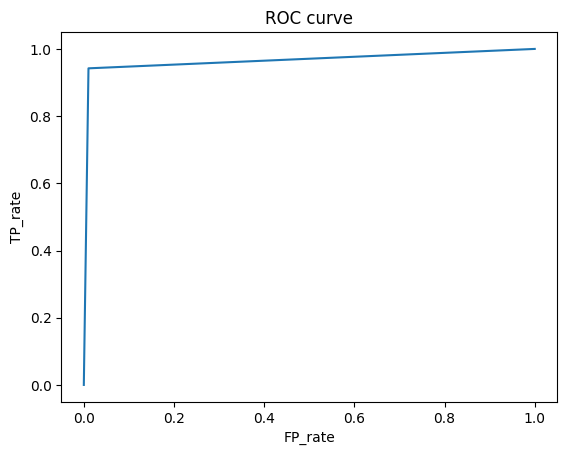

In [17]:
FP_rate, TP_rate, threshold = roc_curve(ytrue, predictions)

# plot
plt.plot(FP_rate, TP_rate)
plt.xlabel('FP_rate')
plt.ylabel('TP_rate')
plt.title('ROC curve')
plt.show()

In [40]:
accuracy  = accuracy_score(ytrue, predictions)
precision = precision_score(ytrue, predictions)
recall    = recall_score(ytrue, predictions)

print('Accuracy = ', accuracy)
print('Precision (purity) = ', precision)
print('Completeness (recall)= ', recall)

Accuracy =  0.9826666666666667
Precision (purity) =  0.9405405405405406
Completeness (recall)=  0.9422382671480144


In [19]:
# Confusion matrix
ytrue_tf         = tf.convert_to_tensor(ytrue, dtype=tf.int32)
predictions_tf   = tf.convert_to_tensor(predictions, dtype=tf.int32)
confusion_matrix = tf.math.confusion_matrix(ytrue_tf, predictions_tf, num_classes=2)

In [20]:
classes = ['Galaxy', 'Quasar']
a = confusion_matrix.numpy()
a_ = [[str(cell) for cell in row] for row in a]
horizontal = ['True  /  Pred'] + classes
tabella = [[col] + row for col, row in zip(classes, a_)]
tabulate(tabella, headers = horizontal, tablefmt='html', numalign='center')

True / Pred,Galaxy,Quasar
Galaxy,6326,66
Quasar,64,1044


5. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do your best now to optimize the network architecture. Be creative!

In [21]:
import keras_tuner

The model I built has as hyperparameter the number of neurons in the hidden (dense) layer. <br>
Another thing I can change is the learning rate with which the model is learning.

In [22]:
def dense_layer(x, num_neurons):
    x = layers.Dense(num_neurons, activation='relu')(x)
    return x

def model_opt(l:int, num_neurons:int, learning_rate):
    inputs  = layers.Input(shape=(l,))
    x       = dense_layer(inputs, num_neurons)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model   = tf.keras.Model(inputs, outputs, name='model_opt')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model

In [30]:
class hypermodel(keras_tuner.HyperModel):
    
    def __init__(self, l):
        self.l = l
    
    def build(self, hp, new = True):
        
        if new:
            
            num_neurons       = hp.Int('num_neurons', min_value=5, max_value=100, step=1)
            learning_rate     = hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='log')
    
        else:
            num_neurons       = hp.get('num_neurons')
            learning_rate     = hp.get('learning_rate')

        
        model = model_opt(self.l, num_neurons = num_neurons, learning_rate = learning_rate)
        
        return model


tuner = keras_tuner.BayesianOptimization( hypermodel(l = 4),
                                              objective  = keras_tuner.Objective('val_accuracy', direction='max'),
                                              max_trials = 20,
                                              max_retries_per_trial = 1
                                               )
tuner.search_space_summary()

Reloading Tuner from ./untitled_project/tuner0.json
Search space summary
Default search space size: 2
num_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 100, 'step': 1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [24]:
# search for the optimal hyperparameters
tuner.search(train_batches, epochs = epochs, steps_per_epoch = steps_per_epochs, validation_steps = validation_steps, validation_data = validation_batches)

Trial 20 Complete [00h 00m 55s]
val_accuracy: 0.984714686870575

Best val_accuracy So Far: 0.987432062625885
Total elapsed time: 00h 18m 05s


In [25]:
# Reload the best hyperparameters
tuner.reload()
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
hyperpar_names = ['num_neurons', 'learning_rate']
for pp in hyperpar_names:
    print('Best Value for parameter {} : {}'.format(pp,best_hps.get(pp)))
print(best_hps.space)

Best Value for parameter num_neurons : 100
Best Value for parameter learning_rate : 0.0038564279223000262
[Int(name: 'num_neurons', min_value: 5, max_value: 100, step: 1, sampling: linear, default: 5), Float(name: 'learning_rate', min_value: '1e-05', max_value: '0.1', step: 'None', sampling: 'log', default: '1e-05')]


In [31]:
model_opt         = tuner.hypermodel.build(best_hps, new=False)    
model_history_opt = model_opt.fit(train_batches, epochs = epochs,
                          steps_per_epoch = steps_per_epochs,
                          validation_steps = validation_steps,
                          validation_data = validation_batches)

Epoch 1/50
546/546 [==============================] - 1s 2ms/step - loss: 0.1790 - accuracy: 0.9659 - val_loss: 0.0690 - val_accuracy: 0.9823
Epoch 2/50
546/546 [==============================] - 1s 2ms/step - loss: 0.0773 - accuracy: 0.9825 - val_loss: 0.0624 - val_accuracy: 0.9817
Epoch 3/50
546/546 [==============================] - 1s 2ms/step - loss: 0.0735 - accuracy: 0.9825 - val_loss: 0.0624 - val_accuracy: 0.9834
Epoch 4/50
546/546 [==============================] - 1s 2ms/step - loss: 0.0712 - accuracy: 0.9828 - val_loss: 0.0608 - val_accuracy: 0.9840
Epoch 5/50
546/546 [==============================] - 1s 2ms/step - loss: 0.0697 - accuracy: 0.9830 - val_loss: 0.0599 - val_accuracy: 0.9840
Epoch 6/50
546/546 [==============================] - 1s 2ms/step - loss: 0.0679 - accuracy: 0.9829 - val_loss: 0.0577 - val_accuracy: 0.9847
Epoch 7/50
546/546 [==============================] - 1s 2ms/step - loss: 0.0672 - accuracy: 0.9831 - val_loss: 0.0594 - val_accuracy: 0.9840
Epoch 

In [32]:
def display_learning_curves(history):

    acc      = history["accuracy"]
    val_acc  = history["val_accuracy"]

    loss     = history["loss"]
    val_loss = history["val_loss"]

    epochs_range = range(epochs)

    fig = plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validation accuracy")
    plt.ylim(0.95,1)
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validation loss")
    plt.ylim(0,0.3)
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    fig.tight_layout()
    plt.show()

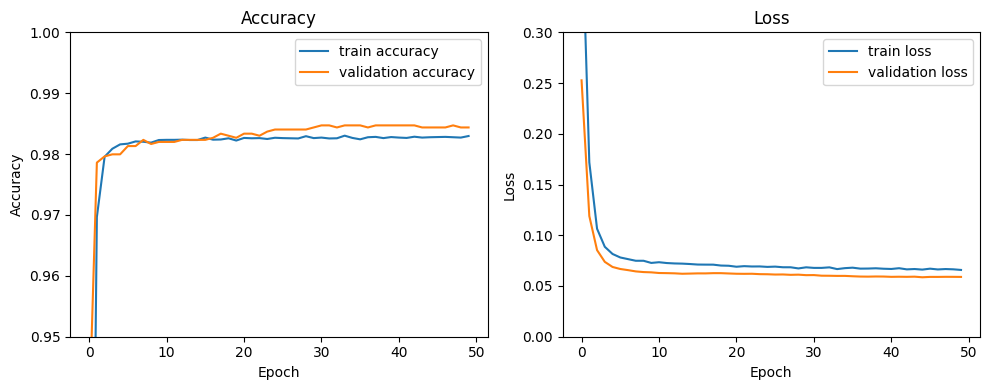

In [33]:
# Display learning curves
display_learning_curves(model_history.history)

In [34]:
test_size = test.cardinality().numpy()

predictions_opt = []
ytrue_opt = []

for features, labels in test.take(test_size):
    # I need to add tf.newaxis at the beginning because the model accepts an input shape of dimension #batches, features
    pred = model.predict(features[tf.newaxis, ...], verbose = 0)
    pred = np.round(pred)
    predictions_opt.append(int(pred[0][0]))
    ytrue_opt.append(labels.numpy())

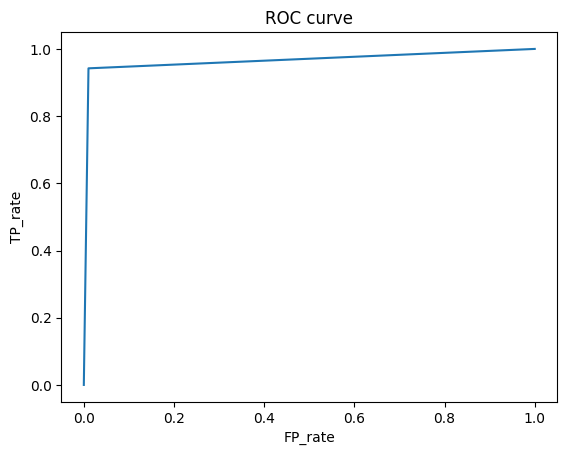

In [39]:
FP_rate_opt, TP_rate_opt, threshold_opt = roc_curve(ytrue_opt, predictions_opt)

# plot
plt.plot(FP_rate_opt, TP_rate_opt)
plt.xlabel('FP_rate')
plt.ylabel('TP_rate')
plt.title('ROC curve')
plt.show()

In [43]:
accuracy_opt  = accuracy_score(ytrue_opt, predictions_opt)
precision_opt = precision_score(ytrue_opt, predictions_opt)
recall_opt    = recall_score(ytrue_opt, predictions_opt)

print('Accuracy = ', accuracy_opt)
print('Precision (purity) = ', precision_opt)
print('Completeness (recall)= ', recall_opt)

Accuracy =  0.9826666666666667
Precision (purity) =  0.9405405405405406
Completeness (recall)=  0.9422382671480144


In [36]:
# Confusion matrix
ytrue_tf_opt         = tf.convert_to_tensor(ytrue_opt, dtype=tf.int32)
predictions_tf_opt   = tf.convert_to_tensor(predictions_opt, dtype=tf.int32)
confusion_matrix_opt = tf.math.confusion_matrix(ytrue_tf_opt, predictions_tf_opt, num_classes=2)

In [37]:
classes = ['Galaxy', 'Quasar']
a = confusion_matrix_opt.numpy()
a_ = [[str(cell) for cell in row] for row in a]
horizontal = ['True  /  Pred'] + classes
tabella_opt = [[col] + row for col, row in zip(classes, a_)]
tabulate(tabella_opt, headers = horizontal, tablefmt='html', numalign='center')

True / Pred,Galaxy,Quasar
Galaxy,6326,66
Quasar,64,1044


Comparison between simple model and the optimized one.

In [53]:
metrics_  = np.array([[accuracy, precision, recall],[accuracy_opt, precision_opt, recall_opt]])
col_names = ['accuracy', 'precision', 'completeness']
row_names = ['simple model', 'optimized']
tabella_  = [[col] + list(row) for col, row in zip(row_names, metrics_)]
headers   = [''] + col_names
tabulate(tabella_, headers=headers, tablefmt='html')

,accuracy,precision,completeness
simple model,0.982667,0.940541,0.942238
optimized,0.982667,0.940541,0.942238
